In [1]:
# Basic packages
import os
import sys
import warnings
import cufflinks as cf
import numpy as np
from numpy.linalg import multi_dot
import pandas as pd

# Plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from statsmodels.graphics.tsaplots import plot_acf

# Optimization packagaes
import gurobipy as gp
from gurobipy import GRB
import gurobipy_pandas as gppd
import scipy.sparse as sp

# Statistical packages
import scipy.stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.stattools import durbin_watson

In [2]:
init_notebook_mode(connected=True)
%matplotlib inline
sns.set_style("dark")
plt.style.use("ggplot")
cf.go_offline()
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option('display.float_format', '{:.5f}'.format)

In [3]:
df = pd.read_csv(r"..\data\ridership\daily.csv")

In [4]:
en_cols = []
for i in range(df.shape[1]):
    if df.columns[i].endswith("en") is True:
        en_cols.append(df.columns[i])
        
ex_cols = []
for i in range(df.shape[1]):
    if df.columns[i].endswith("ex") is True:
        ex_cols.append(df.columns[i])

y_T = df[ex_cols].copy()
print(f"y_T has {y_T.shape[0]} rows and {y_T.shape[1]} columns")
q_T = df[en_cols].copy()
print(f"q_T has {q_T.shape[0]} rows and {q_T.shape[1]} columns")
K = q_T.shape[0]

y_T has 635 rows and 13 columns
q_T has 635 rows and 13 columns


In [5]:
y_T.columns

Index(['Recto-ex', 'Legarda-ex', 'Pureza-ex', 'Vmapa-ex', 'Jruiz-ex',
       'Gilmore-ex', 'Bettygo-ex', 'Cubao-ex', 'Anonas-ex', 'Katipunan-ex',
       'Santolan-ex', 'Marikina-ex', 'Antipolo-ex'],
      dtype='object')

In [6]:
for i in range(q_T.shape[1]):
    q_T[q_T.columns[i]] = q_T[q_T.columns[i]].str.replace(",","").astype(np.int32)
    
for i in range(y_T.shape[1]):
    y_T[y_T.columns[i]] = y_T[y_T.columns[i]].str.replace(",","").astype(np.int32)

In [7]:
y = y_T.T
q = q_T.T

In [8]:
class OnlineVariance(object):
    
    def __init__(self, iterable=None, ddof=1):
        self.ddof, self.n, self.mean, self.M2 = ddof, 0, 0.0, 0.0
        if iterable is not None:
            for datum in iterable:
                self.include(datum)

    def include(self, datum):
        self.n += 1
        self.delta = datum - self.mean
        self.mean += self.delta / self.n
        self.M2 += self.delta * (datum - self.mean)

    @property
    def variance(self):
        if (self.n - self.ddof) != 0:
            return self.M2 / (self.n - self.ddof)
        return self.M2 / self.n

    @property
    def std(self):
        return np.sqrt(self.variance)

In [9]:
Q_T = pd.DataFrame(columns=q_T.columns)
Y_T = pd.DataFrame(columns=y_T.columns)

In [10]:
for i in range(q_T.shape[1]):
    ov = OnlineVariance(ddof=1)
    empty = []
    dummy = q_T[q_T.columns[i]]
    dummy = dummy.to_numpy()
    for j in dummy:
        ov.include(j)
        std = ov.std
        empty.append(std)
    Q_T[q_T.columns[i]] = empty

In [11]:
for i in range(y_T.shape[1]):
    ov = OnlineVariance(ddof=1)
    empty = []
    dummy = y_T[y_T.columns[i]]
    dummy = dummy.to_numpy()
    for j in dummy:
        ov.include(j)
        std = ov.std
        empty.append(std)
    Y_T[y_T.columns[i]] = empty

In [12]:
a = np.dot(y_T, y)
b = Q_T.to_numpy()
c = y.to_numpy()
d = q_T.to_numpy()
e = q.to_numpy()
# f = 2 * b @ B @ c
# g = d @ B @ B.T @ e
Kinv = 1/q.shape[1]

In [13]:
joined = pd.concat([y_T.copy(), q_T.copy()], axis=1)
joined.columns = joined.columns.str.replace("-", "")

In [14]:
# ols = ols('Rectoex ~ Rectoen', data=joined).fit()

In [15]:
# dir(ols)

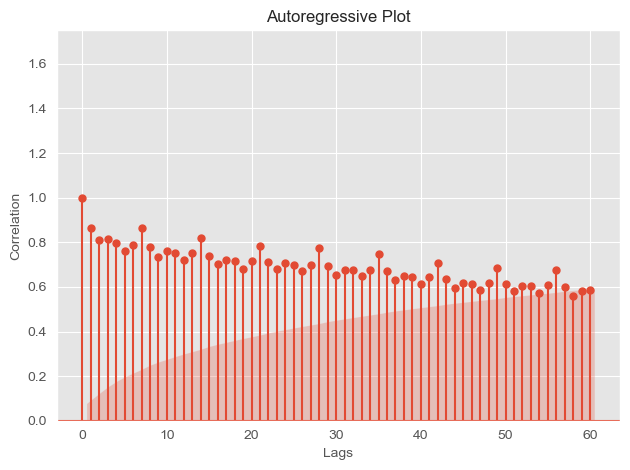

In [26]:
plot_acf(joined['Rectoen'], lags=60)
plt.ylim(0,1.75)
plt.xlabel('Lags', fontsize=10)
plt.ylabel('Correlation', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Autoregressive Plot', fontsize=12)
plt.tight_layout()

In [17]:
def splitb(df, q, y):
    iv = df[y]
    dv = df[q]
    model = sm.OLS(dv, iv, data=df).fit()
    residuals = model.resid
    incrdw = np.ndarray(shape=(model.resid.shape[0], 1), dtype=float)
    for i in range(residuals.shape[0]):
        if i != 0:
            incrdw[i, 0] = (((residuals[i] + residuals[i-1]) ** 2) / ((residuals[i]) ** 2))
        else:
            incrdw[i, 0] = (((residuals[i]) ** 2) / ((residuals[i]) ** 2))
    result = scipy.stats.kendalltau(df[y], incrdw, nan_policy="omit")
#     return incrdw
    return abs(result[0])

In [18]:
split_b = pd.DataFrame(columns=y_T.columns.str.replace("-", ""), index=q_T.columns.str.replace("-", ""))
split_b = split_b.iloc[::-1, ::-1]

In [19]:
for i in q_T.columns.str.replace("-", ""):
    for j in y_T.columns.str.replace("-", ""):
        split_b.loc[i, j] = splitb(joined, i, j)

In [20]:
# split_b.to_csv("splitparameters.csv")

In [21]:
# m.modelSense = GRB.MINIMIZE
# m.setObjective((Kinv * ((a - f + g).sum(axis=0))).max(axis=1))

In [22]:
# m.addConstrs(for i in B.shape[0] for j in B.shape[1] B.sum(1))

In [23]:
# help(GRB.attr)